# Data preperation for a public health organisation

## Exploratory data analysis

This notebook outlines the data processing steps for analyzing the Open Food Facts dataset. The workflow is divided into three key stages:
1. Univariate analysis
2. Bivariate analysis
3. Multivariate analysis 

## Instructions for Use

1. Run the P3_data_processing file to obtain the processed data csv.
2. Update the file paths in the code below to match your local directory structure.

In [4]:
# File paths [update with your file path]
data_path = (
    '/Users/nataschajademinnitt/Documents/5. Data Analysis/'
    'open_classrooms/project_3/data/processed/'
)

figures_path = (
    '/Users/nataschajademinnitt/Documents/5. Data Analysis/'
    'open_classrooms/project_3/results/figures/'
)

### Load data

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from sklearn.preprocessing import MinMaxScaler

# Set environment
pd.set_option('display.float_format', '{:.1f}'.format)
sns.set_theme(style="whitegrid", context="paper")

In [8]:
# Load the file
raw = pd.read_csv(data_path + 'processed_df.csv', low_memory=False)
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46594 entries, 0 to 46593
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        46594 non-null  object 
 1   brands              46594 non-null  object 
 2   saturated-fat_100g  46594 non-null  float64
 3   sugars_100g         46594 non-null  float64
 4   sodium_100g         46594 non-null  float64
 5   fiber_100g          46594 non-null  float64
 6   proteins_100g       46594 non-null  float64
 7   fat_100g            46594 non-null  float64
 8   carbohydrates_100g  46594 non-null  float64
 9   energy_100g         46594 non-null  float64
 10  pnns_groups_1       46594 non-null  object 
 11  nutrition_grade_fr  46594 non-null  object 
dtypes: float64(8), object(4)
memory usage: 4.3+ MB


## Univariate analysis

In [230]:
# Name clarity for visualiations
df_uni = raw.copy()
df_uni.rename(
    columns=lambda x: x.replace('_100g', '')
                      .replace('_fr', '')
                      .replace('-', ' ')
                      .replace('_', ' ')
                      .title(),
    inplace=True
)

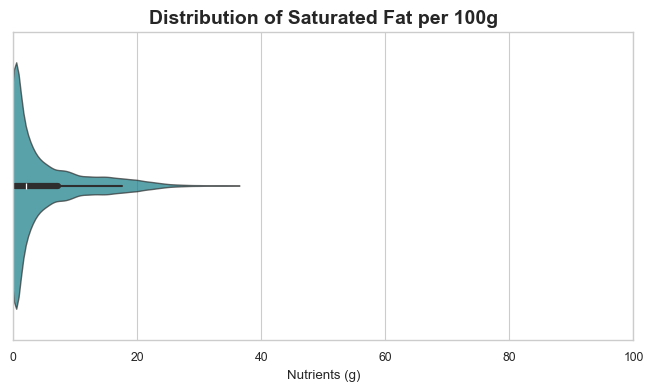

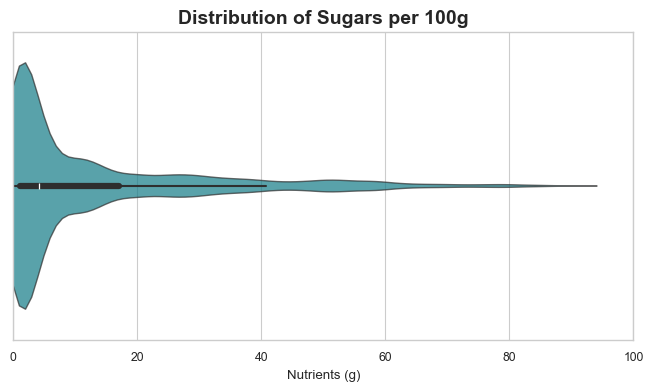

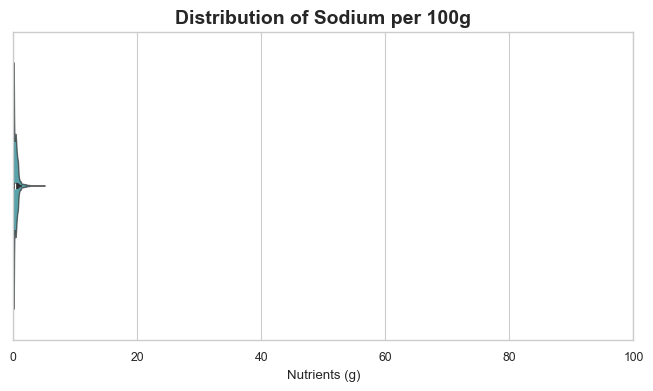

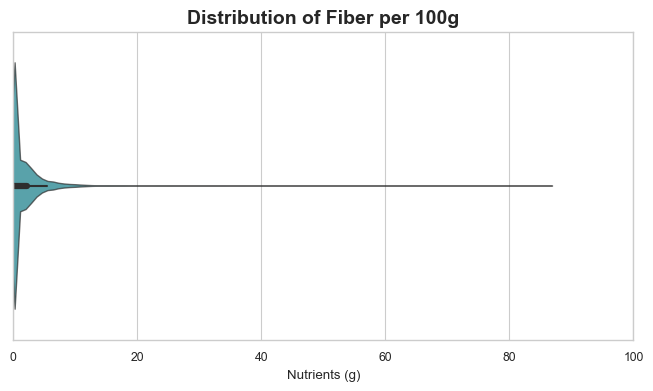

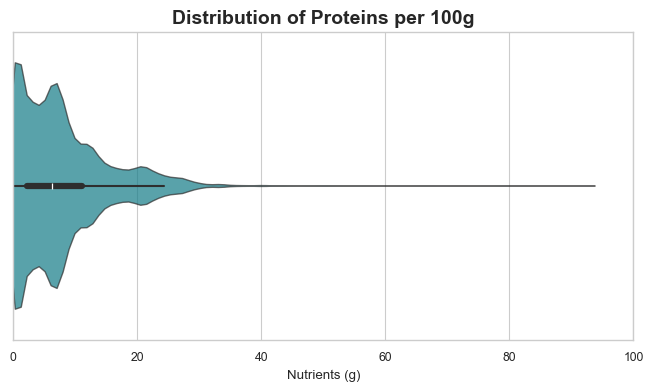

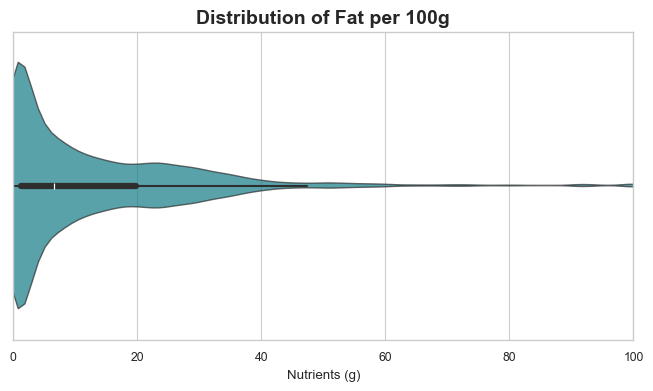

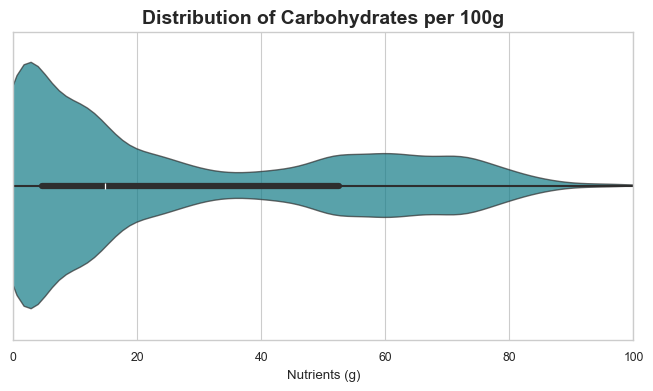

In [239]:
# Violin plot for numeric columns
columns = (df_uni.iloc[:, 2:9])

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x=df_uni[col], color='#008b9a', alpha = 0.7)
    plt.title(f'Distribution of {col} per 100g', fontsize=14, fontweight='bold')
    plt.xlabel('Nutrients (g)')
    plt.xlim(0, 100)
    plt.savefig(f"{figures_path}violin_plot_for_{col}.png", dpi=300)
    plt.show()

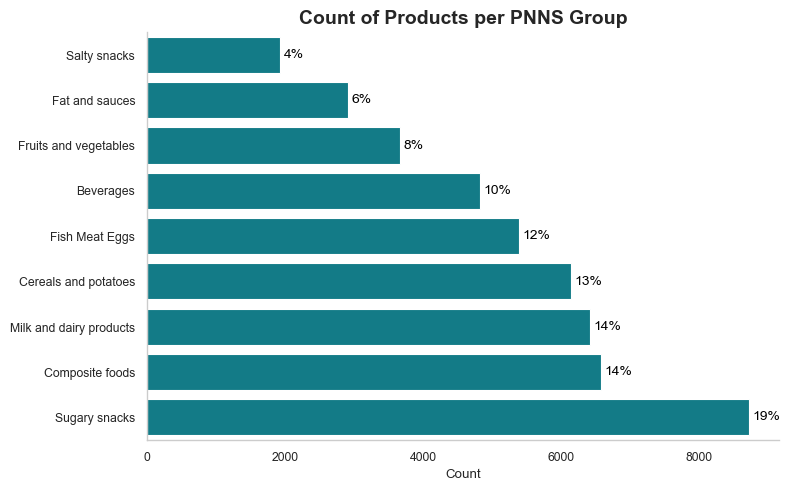

In [266]:
# Count occurrences
count = raw['pnns_groups_1'].value_counts()
count = count.sort_values()

# Plot bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=count.values, y=count.index, color="#008b9a")

# Annotate
for p in ax.patches:
    percent = p.get_width() / count.sum() * 100
    ax.annotate(f'{percent:.0f}%',
                (p.get_width() + 50, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("")
plt.title("Count of Products per PNNS Group", fontsize=14, fontweight='bold')
sns.despine(top=True, right=True)
plt.grid(False)

# Display
plt.tight_layout()
plt.savefig(figures_path + 'count_pnns_groups.png', dpi=300)
plt.show()

## Bivariate analysis

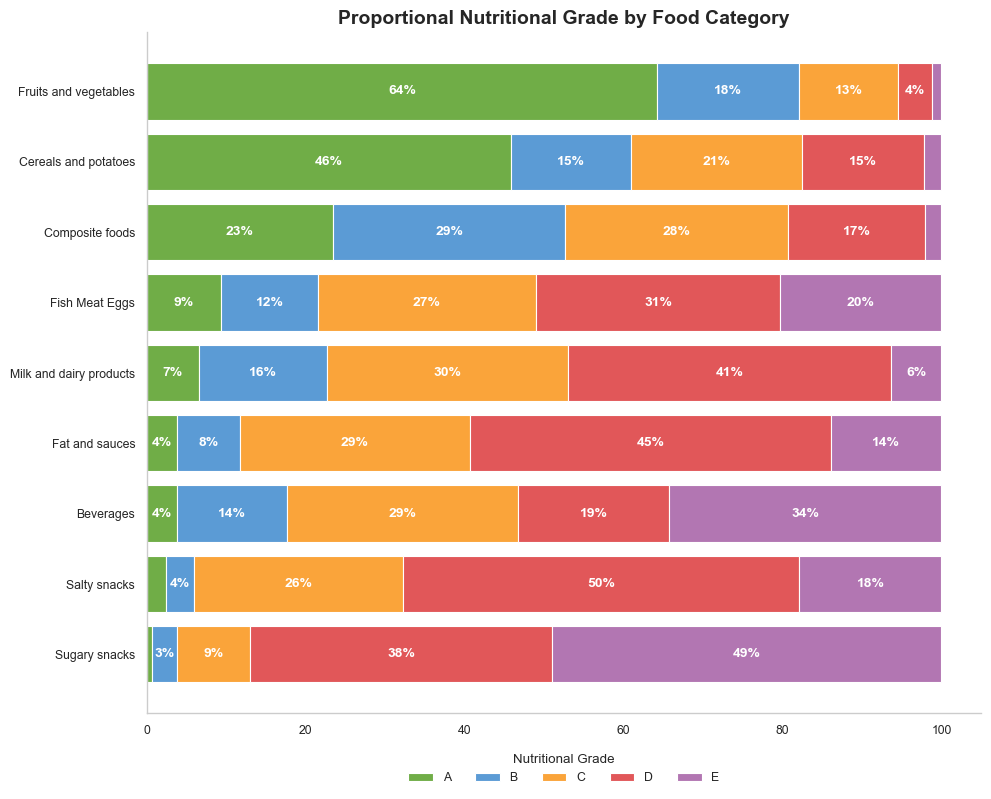

In [276]:
df_bi = raw.copy()

# Cross-tabulate
pivot_table = pd.crosstab(df_bi['pnns_groups_1'], df_bi['nutrition_grade_fr'])
pivot_table_percent = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_percent = pivot_table_percent.sort_values(by='a', ascending=True)

# Order
grades_order = ['a', 'b', 'c', 'd', 'e']

colors = {
    'a': '#70AD47',
    'b': '#5B9BD5',
    'c': '#FAA43A',
    'd': '#E15759',
    'e': '#B276B2'
}

# Horizontal stacked bar plot
fig, ax = plt.subplots(figsize=(10, 8))

for i, grade in enumerate(grades_order):
    if grade in pivot_table_percent.columns:
        left = pivot_table_percent[grades_order[:i]].sum(axis=1) if i > 0 else 0
        ax.barh(
            pivot_table_percent.index,
            pivot_table_percent[grade],
            left=left,
            color=colors.get(grade),
            label=grade.upper()
        )

# Label
for i, cat in enumerate(pivot_table_percent.index):
    cumulative_left = 0
    for grade in grades_order:
        value = pivot_table_percent.loc[cat, grade] if grade in pivot_table_percent.columns else 0
        if value > 3:
            ax.text(cumulative_left + value/2, i, f"{int(round(value))}%", 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        cumulative_left += value

# Customize
ax.set_xlabel('')
ax.set_title('Proportional Nutritional Grade by Food Category', fontsize=14, fontweight='bold')
sns.despine(fig=None, ax=None)
plt.grid(False)
ax.legend(title='Nutritional Grade', loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=5, frameon=False)

# Display
plt.tight_layout()
plt.savefig(figures_path + 'proportional_nutritional_grade_food_cat.png', dpi=300)
plt.show()

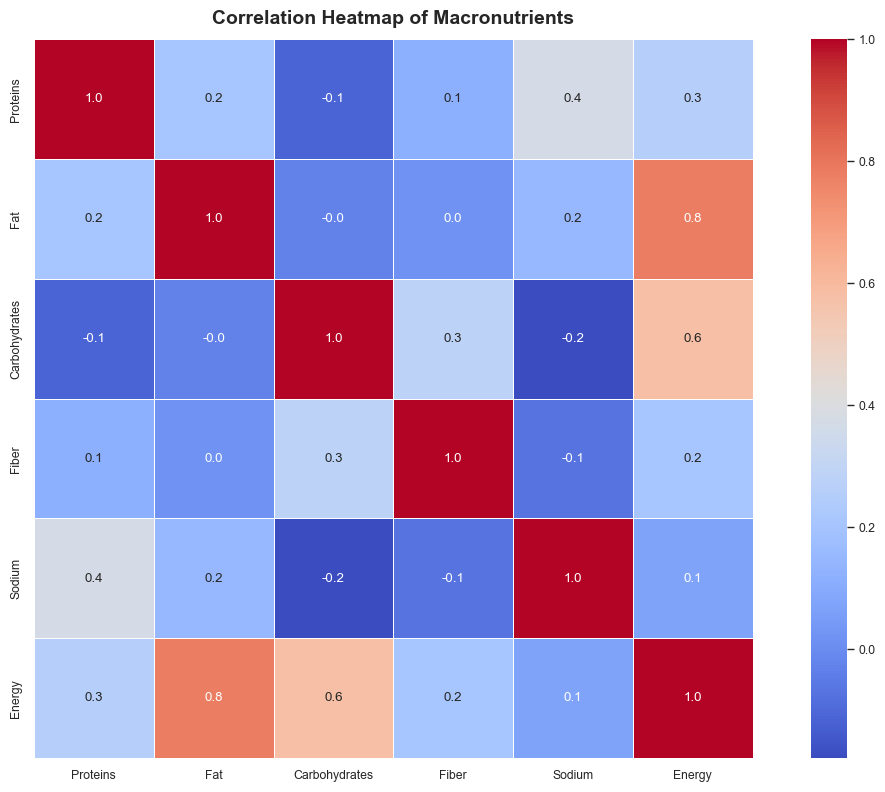

In [580]:
# Correlation heatmap
features = ['Proteins', 'Fat', 'Carbohydrates', 'Fiber', 'Sodium', 'Energy']
numeric = df_uni[features]

correlation_matrix = numeric.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".1f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True, 
    linewidths=0.5
)
plt.title("Correlation Heatmap of Macronutrients", fontsize=14, weight='bold', y=1.01)

# Save
plt.tight_layout()
plt.savefig(figures_path + "correlation_heatmap", dpi=300)
plt.show()

In [18]:
check = raw.groupby('nutrition_grade_fr')['fiber_100g'].median()
check

nutrition_grade_fr
a   2.4
b   0.5
c   0.0
d   0.0
e   0.0
Name: fiber_100g, dtype: float64

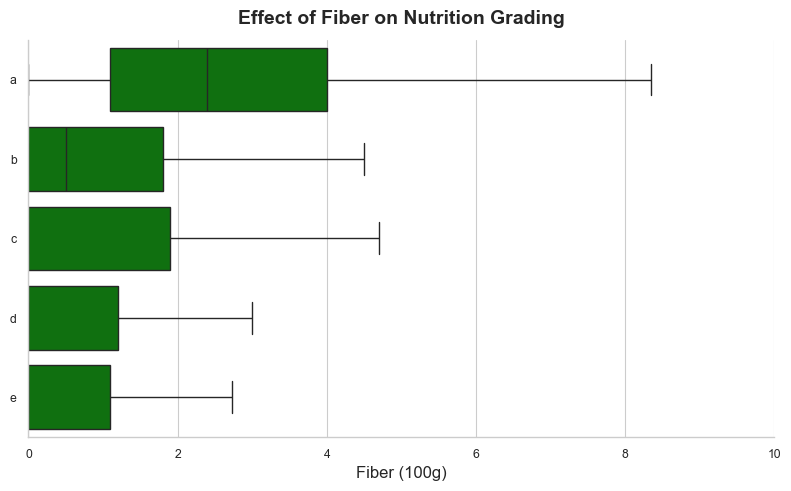

In [280]:
# Effect of fiber on nutrition grading
df_sorted = df_uni.sort_values("Nutrition Grade", ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_sorted, x="Fiber", y="Nutrition Grade", showfliers=False, color='green')

# Format
plt.title("Effect of Fiber on Nutrition Grading", fontsize=14, weight='bold', y=1.02)
plt.xlabel("Fiber (100g)", fontsize=12)
plt.ylabel("")
plt.xlim(0, 10)
sns.despine(top=True, right=True)

# Save
plt.tight_layout()
plt.savefig(figures_path + 'nutrition_grade_fiber.png', dpi=300)
plt.show()

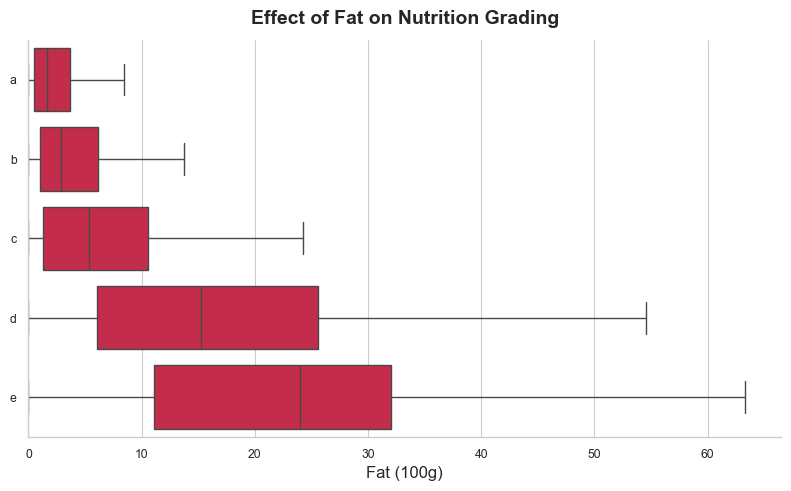

In [285]:
# Effect of fat on nutrition grading
df_sorted = df_uni.sort_values("Nutrition Grade", ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_sorted, x="Fat", y="Nutrition Grade", showfliers=False, color='crimson')

# Format
plt.title("Effect of Fat on Nutrition Grading", fontsize=14, weight='bold', y=1.02)
plt.xlabel("Fat (100g)", fontsize=12)
plt.ylabel("")
plt.xlim(0, None)
sns.despine(top=True, right=True)

# Save
plt.tight_layout()
plt.savefig(figures_path + 'nutrition_grade_fat.png', dpi=300)
plt.show()

## Multivariate analysis

### ANOVA 

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

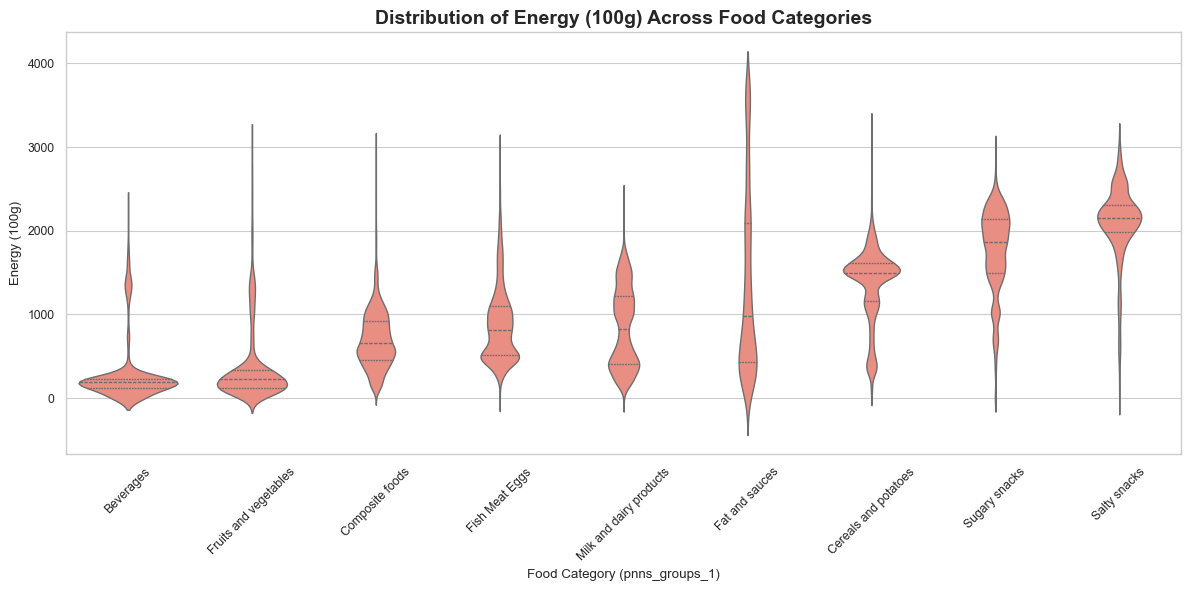

In [306]:
# Violin plot of the differences between pnns_groups_1 and energy_100g
order = df_bi.groupby('pnns_groups_1')['energy_100g'].median().sort_values().index.tolist()
plt.figure(figsize=(12, 6))
sns.violinplot(x='pnns_groups_1', y='energy_100g', data=df_bi, order=order, inner='quartile', color='salmon')
plt.title('Distribution of Energy (100g) Across Food Categories', fontsize=14, fontweight='bold')
plt.xlabel('Food Category (pnns_groups_1)')
plt.ylabel('Energy (100g)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(figures_path + 'energy_per_food_category.png', dpi=300)
plt.show()

***Check ANOVA assumptions***

In [292]:
# Homogeneity of variance
groups = df_bi['pnns_groups_1'].unique()
energy_by_group = [df_bi.loc[df_bi['pnns_groups_1'] == group, 'energy_100g'] for group in groups]

levene_stat, levene_p = stats.levene(*energy_by_group)
print("\nLevene's Test for Homogeneity of Variances:")
print("Test statistic:", levene_stat)
print("p-value:", levene_p) # A p-value > 0.05 typically indicates that the variances are equal across groups.

# Check for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\nShapiro-Wilk Test for Normality of Residuals:")
print("Test statistic:", shapiro_stat)
print("p-value:", shapiro_p) # A p-value > 0.05 typically indicates that the residuals do not significantly deviate from normality.


Levene's Test for Homogeneity of Variances:
Test statistic: 1105.3954439190697
p-value: 0.0

Shapiro-Wilk Test for Normality of Residuals:
Test statistic: 0.9137839078903198
p-value: 0.0


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes.

In [310]:
# Run the Kruskal-Wallis H-test
groups = [group['energy_100g'].values for name, group in df_bi.groupby('pnns_groups_1')]
kruskal_result = kruskal(*groups)
print("Kruskal-Wallis H-test result:")
print(kruskal_result)

Kruskal-Wallis H-test result:
KruskalResult(statistic=26090.357061795763, pvalue=0.0)


This result suggests that energy content is not uniformly distributed across pnns groups and at least one food category has a different energy distribution compared to the others.

In [316]:
# Run Dunn's post-hoc test
dunn_results = sp.posthoc_dunn(df_bi, val_col='energy_100g', group_col='pnns_groups_1', p_adjust='bonferroni')
print("Dunn's test pairwise p-values:")
print(dunn_results)

Dunn's test pairwise p-values (Bonferroni adjusted):
                         Beverages  Cereals and potatoes  Composite foods  \
Beverages                      1.0                   0.0              0.0   
Cereals and potatoes           0.0                   1.0              0.0   
Composite foods                0.0                   0.0              1.0   
Fat and sauces                 0.0                   0.0              0.0   
Fish Meat Eggs                 0.0                   0.0              0.0   
Fruits and vegetables          0.0                   0.0              0.0   
Milk and dairy products        0.0                   0.0              0.0   
Salty snacks                   0.0                   0.0              0.0   
Sugary snacks                  0.0                   0.0              0.0   

                         Fat and sauces  Fish Meat Eggs  \
Beverages                           0.0             0.0   
Cereals and potatoes                0.0             0.0   

Almost all comparisons are statistically significant (p-value = 0.0), meaning that for most pairs, the energy content differs significantly between food categories.

### PCA

In [583]:
# Perform a PCA on standardized numeric data
df_multi = raw.copy()

features = ['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 
            'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'energy_100g']

X = df_multi[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
pca.n_components_

8

In [585]:
pca.components_

array([[ 0.46201311,  0.2442605 ,  0.06314587,  0.12654699,  0.18457908,
         0.49274802,  0.29108567,  0.58760381],
       [ 0.19426935, -0.5031134 ,  0.44384342, -0.14904813,  0.4201314 ,
         0.2457135 , -0.50061409, -0.0492343 ],
       [-0.31076589, -0.16550121,  0.22964795,  0.72140451,  0.41854716,
        -0.22901563,  0.26738354,  0.06121619],
       [ 0.13996248, -0.34232317, -0.64186696,  0.49275705, -0.16928446,
         0.27379428, -0.32303076, -0.02128941],
       [ 0.14569908,  0.14308899, -0.53451306, -0.23947192,  0.73463747,
        -0.26386529,  0.00471545, -0.07685679],
       [ 0.48360577,  0.53520797,  0.21843472,  0.37427945, -0.02414177,
        -0.19127101, -0.34598664, -0.3674301 ],
       [ 0.61443826, -0.48550254,  0.02937397, -0.0332089 , -0.17635869,
        -0.41230483,  0.42021428, -0.08431812],
       [ 0.0011104 ,  0.00177736, -0.00186702,  0.00133984, -0.11917961,
        -0.54148688, -0.43875142,  0.70716031]])

In [587]:
explained_variance = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_variance)
explained_variance

array([3.34542376e-01, 2.48442708e-01, 1.47125277e-01, 1.04785697e-01,
       7.38269292e-02, 5.59675219e-02, 3.52167449e-02, 9.27457092e-05])

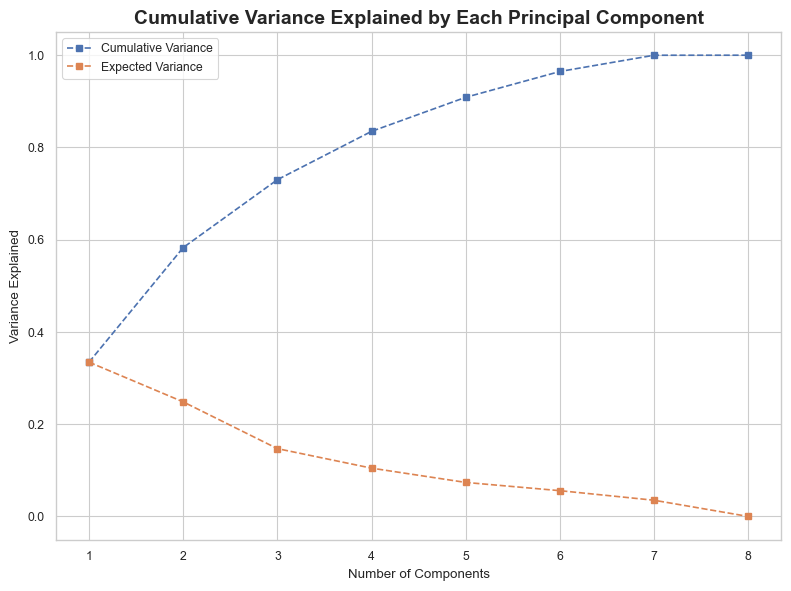

In [589]:
# Scree Plot
plt.figure(figsize=(8,6))
plt.plot(range(1, len(cum_var)+1), cum_var, 's--', label="Cumulative Variance")
plt.plot(range(1, len(explained_variance)+1), explained_variance, 's--', label="Expected Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("Cumulative Variance Explained by Each Principal Component", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(figures_path + 'cum_var_pc.png', dpi=300)
plt.show()

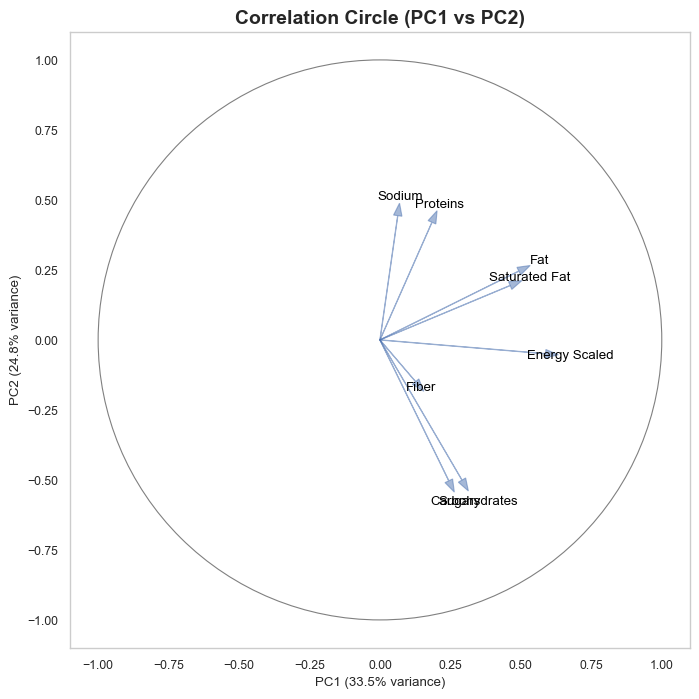

In [574]:
# Correlation Circle (PC1 vs PC2)
loadings = pca.components_.T

plt.figure(figsize=(8,8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)

for i, (var, loading) in enumerate(zip(numeric_cols, loadings)):
    plt.arrow(0, 0, loading[0], loading[1], color='b', alpha=0.5, head_width=0.03)
    plt.text(loading[0]*1.15, loading[1]*1.15, var, color='black', ha='center', va='center')

plt.xlabel("PC1 ({}% variance)".format(round(explained_variance[0]*100, 1)))
plt.ylabel("PC2 ({}% variance)".format(round(explained_variance[1]*100, 1)))
plt.title("Correlation Circle (PC1 vs PC2)", fontsize=14, fontweight='bold')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.savefig(figures_path + 'correlation_circle.png', dpi=300)
plt.show()

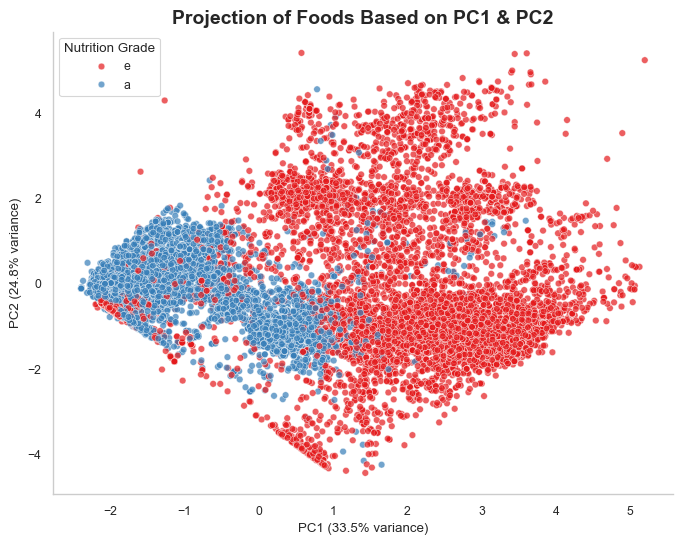

In [536]:
# Scatter plot for the F1-F2 plane by nutrition_grade_fr (a and e)
df_pca = pd.DataFrame(X_pca, 
                      columns=["PC" + str(i+1) for i in range(X_pca.shape[1])], 
                      index=X.index)

df_pca = df_pca.join(df_uni[['Nutrition Grade', 'Pnns Groups 1']])

df_pca_subset = df_pca[df_pca['Nutrition Grade'].isin(['a', 'e'])]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca_subset, x='PC1', y='PC2', hue='Nutrition Grade', 
                palette="Set1", alpha=0.7)
plt.title("Projection of Foods Based on PC1 & PC2", fontweight='bold', fontsize=14)
plt.xlabel("PC1 ({}% variance)".format(round(explained_variance[0]*100, 1)))
plt.ylabel("PC2 ({}% variance)".format(round(explained_variance[1]*100, 1)))
plt.legend(title="Nutrition Grade")
sns.despine(top=True, right=True)
plt.grid()
plt.savefig(figures_path + 'individual_projection_A_vs_E.png', dpi=300)
plt.show()

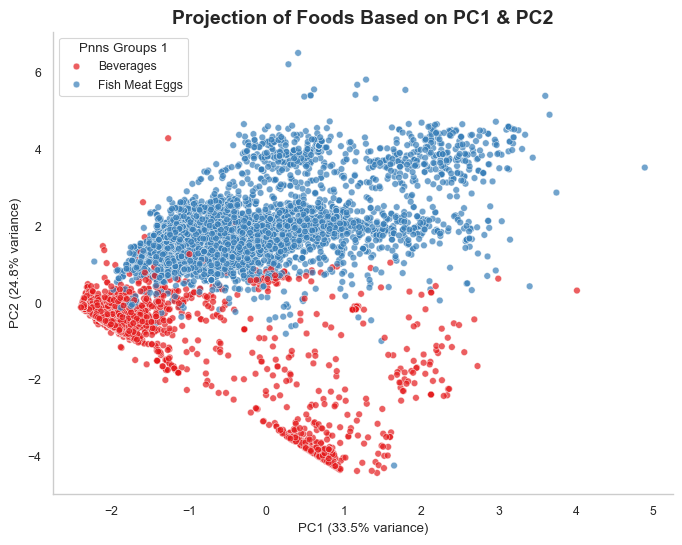

In [560]:
# Scatter plot for the F1-F2 plane by pnns_groups_1
df_pca = pd.DataFrame(X_pca, 
                      columns=["PC" + str(i+1) for i in range(X_pca.shape[1])], 
                      index=X.index)

df_pca = df_pca.join(df_uni[['Nutrition Grade', 'Pnns Groups 1']])

df_pca_subset = df_pca[df_pca['Pnns Groups 1'].isin(['Fish Meat Eggs', 'Beverages'])]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca_subset, x='PC1', y='PC2', hue='Pnns Groups 1', 
                palette="Set1", alpha=0.7)
plt.title("Projection of Foods Based on PC1 & PC2", fontweight='bold', fontsize=14)
plt.xlabel("PC1 ({}% variance)".format(round(explained_variance[0]*100, 1)))
plt.ylabel("PC2 ({}% variance)".format(round(explained_variance[1]*100, 1)))
plt.legend(title="Pnns Groups 1")
sns.despine(top=True, right=True)
plt.grid()
plt.savefig(figures_path + 'individual_projection_pnns_groups.png', dpi=300)
plt.show()